In [164]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import norm, halfnorm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical

import sys
sys.path.append("../src/")
from priors import sample_eta, sample_random_walk
from likelihood import sample_softmax_rl
from context import generate_context
from configurator import configure_input
from helpers import softmax

In [ ]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
TRAIN_NETWORK = False

In [ ]:
LOCAL_PARAM_LABELS = ("Learning rate", "Sensitivity")
LOCAL_PARAM_NAMES = (r"$\alpha$", r"$\tau$")
GLOBAL_PARAM_LABELS = ("Standard deviation", "Standard deviation")
GLOBAL_PARAM_NAMES = (r"$\sigma_{\alpha}$", r"$\sigma_{\tau}$")

FONT_SIZE_1 = 16
FONT_SIZE_2 = 14
FONT_SIZE_3 = 12

GLOBAL_PRIOR_MEAN = halfnorm(0, [0.05, 3]).mean().round(decimals=2)
GLOBAL_PRIOR_STD = halfnorm(0, [0.05, 3]).std().round(decimals=2)
LOCAL_PRIOR_MEAN = np.array([0.6, 20])
LOCAL_PRIOR_STD = np.array([0.3, 20])

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Read Empiric Data

In [ ]:
emp_data = pd.read_csv("../data/data_fontanesi_prep.csv")
emp_data.f_cor = emp_data.f_cor / 60
emp_data.f_inc = emp_data.f_inc / 60

## Exemplar Trajectory

In [ ]:
eta = sample_eta()
theta = sample_random_walk(eta)
time = np.arange(theta.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

### Prior

In [ ]:
prior = beef.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
)

### Context

In [ ]:
context = beef.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
)

### Likelihood

In [ ]:
likelihood = beef.simulation.Simulator(
    simulator_fun=sample_softmax_rl,
    context_generator=context,
)

### Simulator

In [ ]:
model = beef.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="non-stationary_softmax_rl",
)

## Neural Approximator

In [ ]:
approximator_settings = {
    "lstm1_hidden_units": 512,
    "lstm2_hidden_units": 256,
    "lstm3_hidden_units": 128,
    "trainer": {
        "max_to_keep": 1,
        "default_lr": 5e-4,
        "memory": False,
    },
    "local_amortizer_settings": {
        "num_coupling_layers": 8,
        "coupling_design": 'interleaved'
    },
    "global_amortizer_settings": {
        "num_coupling_layers": 6,
        "coupling_design": 'interleaved'
    },
}

In [ ]:
summary_network = beef.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [ ]:
local_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=2,
        **approximator_settings.get("local_amortizer_settings")
    )
)
global_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=2,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [ ]:
amortizer = beef.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)
trainer = beef.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/ns__rl_jumps"
)

## Training

In [ ]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=200,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())

## Validation

In [ ]:
val_data = model(1)
theta_true = val_data['local_prior_draws'][0]
eta_true = val_data['hyper_prior_draws'][0]

In [ ]:
val_data_config = configure_input(val_data)

In [ ]:
val_data_config.keys()

In [ ]:
post_sample = amortizer.sample(val_data_config, n_samples=1000)

### Local Parameters

In [ ]:
theta_post = post_sample['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
theta_post_mean = theta_post.mean(axis=1)
theta_post_std = theta_post.std(axis=1)

In [ ]:
time = np.arange(theta_post_mean.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_post_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.plot(
        time,
        theta_true[:, i],
        color='black', label="True parameter"
    )
    ax.fill_between(
        time,
        theta_post_mean[:, i] - theta_post_std[:, i],
        theta_post_mean[:, i] + theta_post_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
# fig.savefig("../plots/recovered_theta.pdf", dpi=300, bbox_inches="tight")

### Global Parameters

In [ ]:
eta_post = post_sample['global_samples'] * GLOBAL_PRIOR_STD + GLOBAL_PRIOR_MEAN 

In [ ]:
prior_samples = prior(1000)

In [ ]:
prior_eta = prior_samples['hyper_parameters']

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.axvline(
        eta_true[i],
        color='black',
        lw=3,
        label="True parameter"
    )
    sns.histplot(
        eta_post[:, i],
        color='maroon',
        ax=ax,
        alpha=0.5,
        linewidth=0,
        label="Posterior"
    )

    sns.histplot(
        prior_eta[:, i],
        ax=ax,
        alpha=0.25,
        linewidth=0,
        label="Prior"
    )

    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_ylabel("", fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Count", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=3)
    ax.set_xlabel(f'{GLOBAL_PARAM_LABELS[i]} ({GLOBAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
# fig.savefig("../plots/recovered_eta.pdf", dpi=300, bbox_inches="tight")

## Fit to Empirical Data

In [166]:
N_SAMPLES = 2000
# SUBJECTS = emp_data.id.unique()
RELEVANT_SUB = np.array([1, 3, 5, 6, 7, 8, 16, 20, 22, 23, 24, 26, 27])
theta_post = np.zeros((len(RELEVANT_SUB), 240, N_SAMPLES, 2))

In [167]:
for i, sub in enumerate(tqdm(RELEVANT_SUB)):
    person_data = emp_data.loc[emp_data.id == sub][['resp', 'f_cor', 'f_inc', 'cor_option', 'inc_option']].to_numpy()
    resp = person_data[:, 0, None]
    feedback = person_data[:, 1:3]
    cor_option = person_data[:, 3, None]
    inc_option = person_data[:, 4, None]
    data = np.c_[
        resp, feedback, to_categorical(cor_option), to_categorical(inc_option)
    ]
    post_sample = amortizer.sample({'summary_conditions': data[None, :, :]}, n_samples=N_SAMPLES)
    theta_post[i] = post_sample['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN

100%|██████████| 13/13 [02:15<00:00, 10.45s/it]


In [169]:
# theta_post_mean = theta_post.mean(axis=1)
# theta_post_std = theta_post.std(axis=1)
post_means = np.mean(theta_post, axis=2)
post_std = np.std(theta_post, axis=2)
post_means_mean = np.mean(post_means, axis=0)
post_means_std = np.std(post_means, axis=0)

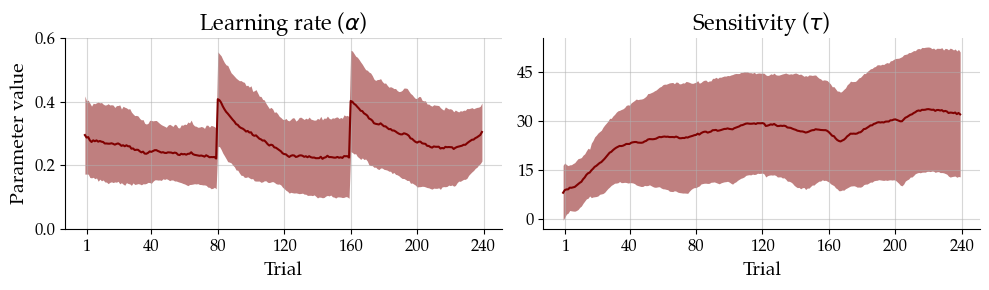

In [186]:
time = np.arange(post_means_mean.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        post_means_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.fill_between( 
        time,
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    xticks = np.arange(0, 240+1, 40)
    xticks[0] = 1
    ax.set_xticks(xticks)
    if i == 0:
        ax.set_yticks(np.arange(0, 0.7, 0.2))
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        # fig.subplots_adjust(hspace=0.5)
        # fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    if i == 1:
        ax.set_yticks(np.arange(0, 51, 15))
    ax.set_xlabel("Trial", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()